### Predicting from the S&P 500 index (ideally)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('all_stocks_5yr.csv')

In [2]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
# how many different companies?
len(set(df['Name']))

505

In [4]:
# select American Airlines Group
aal = df[df['Name']=='AAL']
aal = aal.sort_values("date")

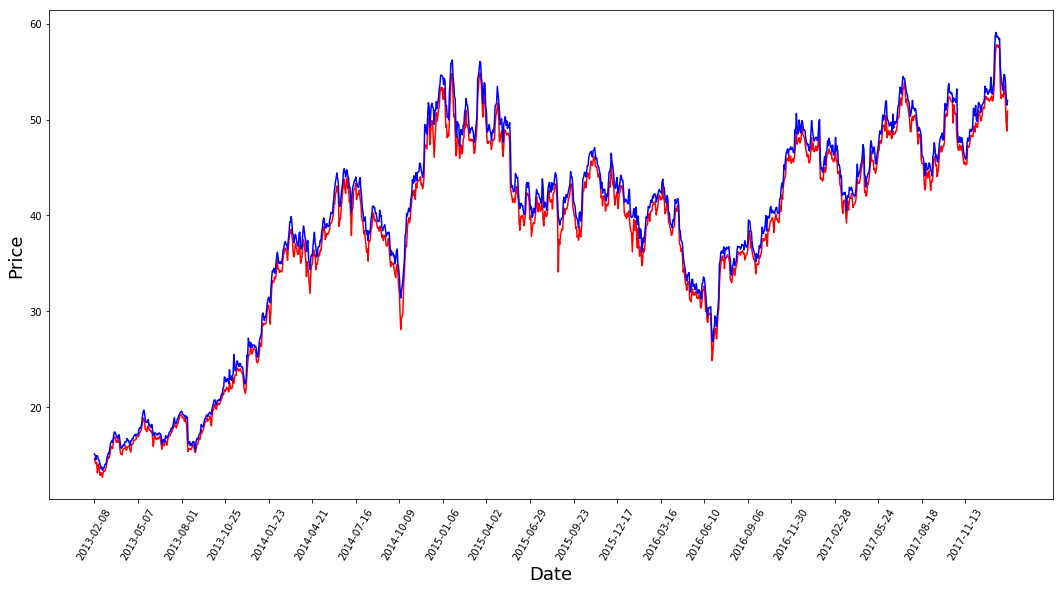

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(aal.shape[0]),(aal['low']), color='r')
plt.plot(range(aal.shape[0]),(aal['high']), color = 'b')
plt.xticks(range(0,aal.shape[0],60),aal['date'].loc[::60],rotation=60)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

The high and low prces both follow a similar pattern.
Hence, we will not use both for the prediction, but take a mean value

In [6]:
high_prices = aal.loc[:,'high'].values
low_prices = aal.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0

In [7]:
mid_prices.shape

(1259,)

In [8]:
mid_prices

array([14.875, 14.635, 14.305, ..., 51.07 , 50.145, 51.435])

In [9]:
# train&test split
train_data = mid_prices[:1000]
test_data = mid_prices[1000:1251]
train_data = train_data.reshape(-1,1)                                                       #scaler.fit_transform
test_data = test_data.reshape(-1,1)    

In [10]:
print('%d training and %d total testing instances'%(len(train_data), len(test_data)))

1000 training and 251 total testing instances


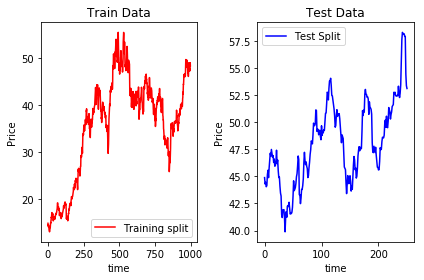

In [11]:
#Subplot with training data
plt.subplot(1,2,1)
plt.plot(range(train_data.shape[0]),train_data,color='r',label='Training split')
plt.title('Train Data')
plt.xlabel('time')
plt.ylabel('Price')
plt.legend()

#Subplot with test data
plt.subplot(1,2,2)
plt.plot(range(test_data.shape[0]),test_data,color='b',label='Test Split')
plt.title('Test Data')
plt.xlabel('time')
plt.ylabel('Price')
plt.legend()

#adjust layout and plot all
plt.tight_layout()
plt.show()

#### Windowed normalization
Instead of normalizing the whole dataset in the same way, it will be done in smaller batches. <br>
Since data ranges in different years can vary a lot, an overall normalization would cause values occurring early in the time series to be extremely close to zero

In [12]:
#Window size to normalize data in chunks 
normalization_window = 250

#Feature range for normalization
scaler = MinMaxScaler(feature_range=(0, 1))


In [13]:
# Loop over the training data in windows of 250 instances at a time
for i in range(0,1000,normalization_window):
    
    # Fit the scaler object on the data in the current window
    scaler.fit(train_data[i:i+normalization_window,:])
    
    # Transform the data in the current window into values between the chosen feature range (0 and 1)
    train_data[i:i+normalization_window,:] = scaler.transform(train_data[i:i+normalization_window,:])
    

In [14]:
# normalize the the test data (just one window)
test_data=scaler.fit_transform(test_data)

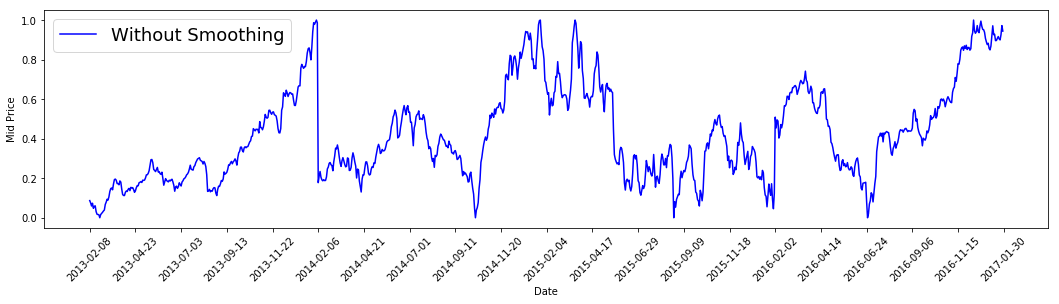

In [15]:
# Plot normalized data
# As it shows, the issue with windowed normalization is the introduction of a discontinuity in the dataset
plt.figure(figsize = (18,4))
plt.plot(range(train_data.shape[0]),train_data,color='b',label='Without Smoothing')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

#### Denoising
There are a lot of small and irrelevant market fluctuations, and it is useful to denoise that. <br>
**Exponential smoothing** will be used, since it allows recent events have a higher influence on the current data point than events
from the distant past. <br>
Each data point can be expressed as a
weighted recursive function of the current value and preceding values in the time series.

In [16]:
Smoothing = 0.0     #Initialize smoothing value as zero

gamma = 0.1         #Define decay


for i in range(1000):
      
    Smoothing = gamma*train_data[i] + (1-gamma)*Smoothing    # Update smoothing value
    
    train_data[i] = Smoothing                                # Replace datapoint with smoothened value

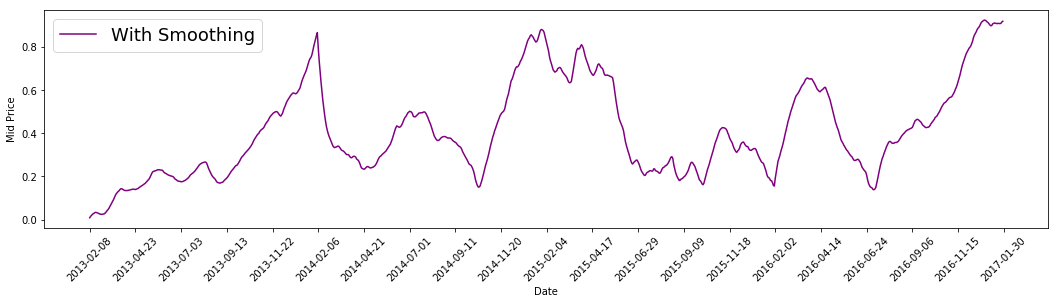

In [17]:
# Plot smooth-ened curve

plt.figure(figsize = (18,4))
plt.plot(range(train_data.shape[0]),train_data,color='purple',label='With Smoothing')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

#### Comparing the LSTM witho other models

In [18]:
# using MSE to evaluate the effectiveness
from sklearn.metrics import mean_squared_error

# simple moving average: the next point is the mean of the previous values

window_size = 26            # Define window size
N = train_data.size         # and length of observations

std_avg_predictions = []    # Empty list to catch std
mse_errors = []             # and mse


for i in range(window_size,N):
    
    std_avg_predictions.append(np.mean(train_data[i-window_size:i]))  # Append the standard mean per window 
    
    mse_errors.append((std_avg_predictions[-1]-train_data[i])**2)     # Compute mean squared error per batch

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00444


In [19]:
print(' No. of obs :' , len(train_data))
print(' Std av. predictions :', len(std_avg_predictions))

 No. of obs : 1000
 Std av. predictions : 974


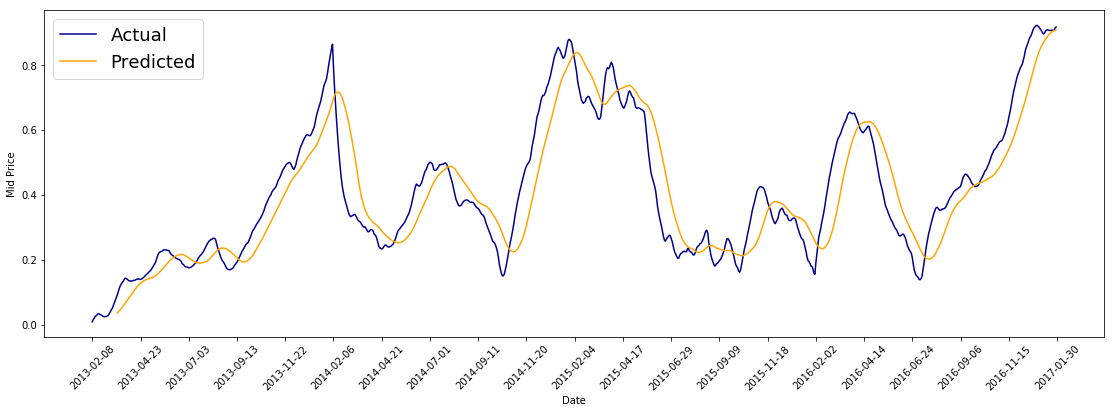

In [20]:
# Plot standard moving average predictions

plt.figure(figsize = (19,6))
plt.plot(range(train_data.shape[0]),train_data,color='darkblue',label='Actual')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Predicted')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

The simple moving average catches the general trend of the dataset, bit it's too slow to make profitable predictions

In [21]:
ob = 200
print('Predicted:', *train_data[ob],  'actual:',std_avg_predictions[ob])

Predicted: 0.4890962384030282 actual: 0.5278803889434908


In [22]:
# Computing Exponential Moving Average (EMA)
# This is the same equations used for smoothing the train dataset

ema_avg_predictions = []
mse_errors = []

EMA = 0.0
ema_avg_predictions.append(EMA)

gamma = 0.5
window_size = 100
N = len(train_data)

for i in range(1,N):
    EMA = EMA*gamma + (1.0-gamma)*train_data[i-1]
    ema_avg_predictions.append(EMA)
    mse_errors.append((ema_avg_predictions[-1]-train_data[i])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00018


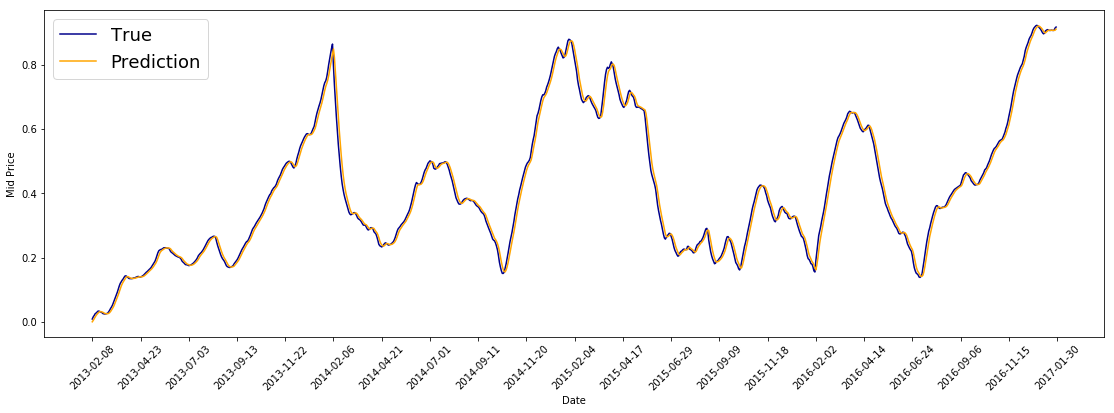

In [23]:
# Plotting EMA predictions 

plt.figure(figsize = (19,6))
plt.plot(range(train_data.shape[0]),train_data,color='darkblue',label='True')
plt.plot(range(0,N),ema_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,aal.shape[0]-len(test_data),50),aal['date'].loc[::50],rotation=45)

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


Very good! But it is just predictiong the stock price one day in advance. <br>
Also, using EMA for predictiong multiple time steps into the future does not work, since in the equation the EMA and X will have the same value during a particualr instant

In [24]:
# Testing on a single observation

num_ob = 25
print('Predicted:', train_data[num_ob],  'Actual:',ema_avg_predictions[num_ob])

Predicted: [0.08368467] Actual: [0.06933803]


### Predicting multiple timesteps into the future

In [25]:
# Function to create dataset (train and test sequences)
# the label for each training sequence will correspond to the stock price four timesteps into the future

def create_dataset(dataset, look_back=7, foresight=3):   
    
    X, Y = [], []
    
    for i in range(len(dataset)-look_back-foresight):
        
        obs = dataset[i:(i+look_back), 0]                   # Sequence of 7 stock prices as features forming an observation
        
        X.append(obs)                                       # Append sequence 
        
        Y.append(dataset[i + (look_back+foresight), 0])     # Append stock price value occuring 4 time-steps into future
        
    return np.array(X), np.array(Y)

In [26]:
# Define lookback window length and lag between label
look_back, foresight = 7, 3

x_train, y_train = create_dataset(train_data, look_back, foresight)
x_test, y_test = create_dataset(test_data, look_back, foresight)

In [27]:
# Reshape data into (timesteps, 1, features)

x_train = np.reshape(x_train, (x_train.shape[0], 1,  x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1,  x_test.shape[1]))

In [28]:
# Check shape

x_train.shape

(990, 1, 7)

In [29]:
# Check and individual observation and its label 

print(x_train[0])
print(y_train[0])

[[0.00867591 0.015337   0.01975454 0.02511656 0.02738502 0.03043046
  0.03341036]]
0.028595272260547346


In [30]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten

from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


### Sanity check
Would the complex LSTM performs better than simpler models?

In [31]:
# Simple feed forward baseline

def feed_forward():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [32]:
# Simple GRU with dropout

def simple_gru():
    model = Sequential()
    model.add(GRU(32,  input_shape=(1, 7), dropout=0.1, recurrent_dropout=0.1))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam', metrics = ['mean_absolute_error'])
    return model
    

In [33]:
# Simple LSTM

def simple_lstm():
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, 7)))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam')
    return model
    

In [34]:
# Stacked LSTM

def lstm_stacked():
    model = Sequential()
    model.add(LSTM(16, input_shape=(1, 7), dropout=0.1, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(16, dropout=0.1, recurrent_dropout=0.2))
    
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae', optimizer='adam')
    return model

In [35]:
# Helper function to plot losses

def plot_losses(network):
    plt.plot(network.history['loss'], label='loss')
    plt.plot(network.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    plt.clf()

In [36]:
# Helper function to plot preds

def plot_predictions(model, y_test=y_test):
    
    preds = model.predict(x_test)
    plt.figure(figsize = (12,6))
    plt.plot(scaler.inverse_transform(preds.reshape(-1,1)), label='generated', color='orange')
    plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='Actual')
    plt.legend()
    plt.show()

In [37]:
def train_network(list_nets, x_train, y_train, epochs=5):
    
    for net in list_nets:               
        
        network_name = str(net).split(' ')[1]
        filepath = network_name + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
        print('Training:', network_name)
        
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        callbacks_list = [checkpoint] 
        model = net()                  
        
        network = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=epochs,
                            batch_size=64,
                            callbacks=callbacks_list)
        model.summary()
        plot_predictions(model, y_test)
        
    return network, model

Training: feed_forward
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 1s 559us/step - loss: 0.1868 - val_loss: 0.1030
Epoch 2/50
990/990 [==============================] - 0s 22us/step - loss: 0.0647 - val_loss: 0.0984
Epoch 3/50
990/990 [==============================] - 0s 21us/step - loss: 0.0509 - val_loss: 0.0883
Epoch 4/50
990/990 [==============================] - 0s 21us/step - loss: 0.0420 - val_loss: 0.0870
Epoch 5/50
990/990 [==============================] - 0s 22us/step - loss: 0.0392 - val_loss: 0.0862
Epoch 6/50
990/990 [==============================] - 0s 20us/step - loss: 0.0378 - val_loss: 0.0859
Epoch 7/50
990/990 [==============================] - 0s 23us/step - loss: 0.0366 - val_loss: 0.0840
Epoch 8/50
990/990 [==============================] - 0s 21us/step - loss: 0.0354 - val_loss: 0.0829
Epoch 9/50
990/990 [==============================] - 0s 21us/step - loss: 0.0344 - val_loss: 0.0820
Epoch 10/50
990/990 [

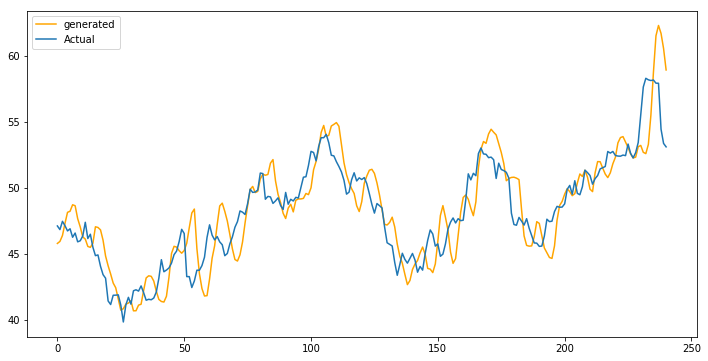

Training: simple_gru
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 0s 464us/step - loss: 0.2237 - mean_absolute_error: 0.2237 - val_loss: 0.1231 - val_mean_absolute_error: 0.1231
Epoch 2/50
990/990 [==============================] - 0s 44us/step - loss: 0.0785 - mean_absolute_error: 0.0785 - val_loss: 0.0896 - val_mean_absolute_error: 0.0896
Epoch 3/50
990/990 [==============================] - 0s 42us/step - loss: 0.0670 - mean_absolute_error: 0.0670 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 4/50
990/990 [==============================] - 0s 42us/step - loss: 0.0631 - mean_absolute_error: 0.0631 - val_loss: 0.0876 - val_mean_absolute_error: 0.0876
Epoch 5/50
990/990 [==============================] - 0s 42us/step - loss: 0.0605 - mean_absolute_error: 0.0605 - val_loss: 0.0886 - val_mean_absolute_error: 0.0886
Epoch 6/50
990/990 [==============================] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.069 -

Epoch 50/50
990/990 [==============================] - 0s 44us/step - loss: 0.0556 - mean_absolute_error: 0.0556 - val_loss: 0.0880 - val_mean_absolute_error: 0.0880
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3840      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


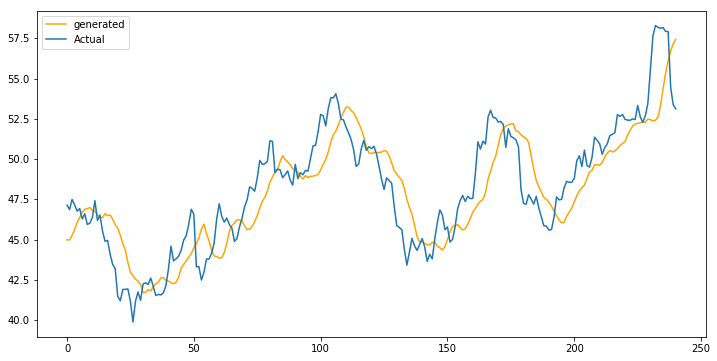

Training: simple_lstm
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 0s 441us/step - loss: 0.3974 - val_loss: 0.3606
Epoch 2/50
990/990 [==============================] - 0s 45us/step - loss: 0.2689 - val_loss: 0.2273
Epoch 3/50
990/990 [==============================] - 0s 43us/step - loss: 0.1358 - val_loss: 0.1112
Epoch 4/50
990/990 [==============================] - 0s 45us/step - loss: 0.0669 - val_loss: 0.0934
Epoch 5/50
990/990 [==============================] - 0s 43us/step - loss: 0.0616 - val_loss: 0.0923
Epoch 6/50
990/990 [==============================] - 0s 45us/step - loss: 0.0555 - val_loss: 0.0922
Epoch 7/50
990/990 [==============================] - 0s 43us/step - loss: 0.0512 - val_loss: 0.0911
Epoch 8/50
990/990 [==============================] - 0s 46us/step - loss: 0.0480 - val_loss: 0.0914
Epoch 9/50
990/990 [==============================] - 0s 46us/step - loss: 0.0462 - val_loss: 0.0912
Epoch 10/50
990/990 [=

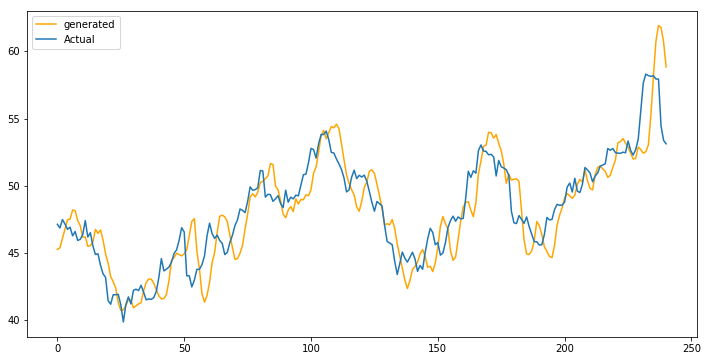

Training: lstm_stacked
Train on 990 samples, validate on 241 samples
Epoch 1/50
990/990 [==============================] - 1s 1ms/step - loss: 0.3795 - val_loss: 0.3781
Epoch 2/50
990/990 [==============================] - 0s 84us/step - loss: 0.3104 - val_loss: 0.2954
Epoch 3/50
990/990 [==============================] - 0s 82us/step - loss: 0.2139 - val_loss: 0.1861
Epoch 4/50
990/990 [==============================] - 0s 85us/step - loss: 0.1122 - val_loss: 0.1037
Epoch 5/50
990/990 [==============================] - 0s 83us/step - loss: 0.0902 - val_loss: 0.0976
Epoch 6/50
990/990 [==============================] - 0s 84us/step - loss: 0.0799 - val_loss: 0.1003
Epoch 7/50
990/990 [==============================] - 0s 84us/step - loss: 0.0746 - val_loss: 0.0960
Epoch 8/50
990/990 [==============================] - 0s 83us/step - loss: 0.0704 - val_loss: 0.0964
Epoch 9/50
990/990 [==============================] - 0s 83us/step - loss: 0.0671 - val_loss: 0.0949
Epoch 10/50
990/990 [==

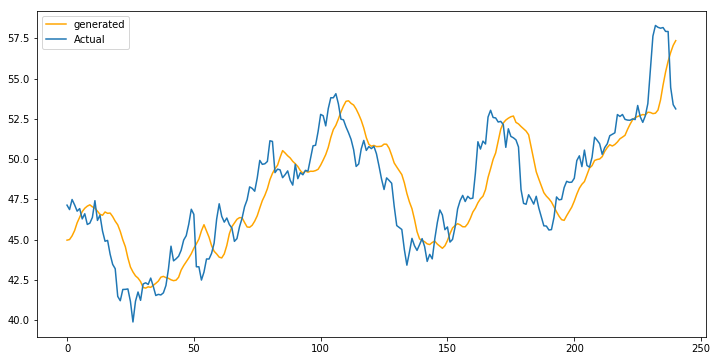

(<keras.callbacks.History at 0x7f21705159e8>,
 <keras.engine.sequential.Sequential at 0x7f2228b7df60>)

In [38]:
all_networks = [feed_forward, simple_gru, simple_lstm, lstm_stacked]
train_network(all_networks, x_train, y_train, epochs=50)

The LSTM does not perform better than the feedforward one. <br>
There might be a lot of complex
signals that the LSTM could model in this context, but they don't seem to be present in the dataset.